In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
# Tensorflow imports
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Input, BatchNormalization, \
    multiply, concatenate, Flatten, Activation, dot
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error

import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')
sns.set(style='whitegrid', palette='deep', font_scale=1.2)

### Load the data and check where is running the notebook

In [ ]:
# Block to load file depending if you are in Colab or in Jupyter
if 'google.colab' in str(get_ipython()):
    print('Running on CoLab')
    !nvidia-smi
    TF_CPP_MIN_LOG_LEVEL=2

    device_name = tf.test.gpu_device_name()
    if device_name != '/device:GPU:0':
      raise SystemError('GPU device not found')
    print('Found GPU at: {}'.format(device_name))
    # get data
    !wget --no-check-certificate \
        https://www.dropbox.com/s/qbn9y5ooqxipxki/single_feature.csv?dl=0 \
        -O /tmp/Features.csv
        
    data = pd.read_csv('/tmp/Features.csv', parse_dates=['Timestamp'], index_col='Timestamp')
else:
    path_of_file = '../Data/single_feature.csv'
    data = pd.read_csv(path_of_file, parse_dates=['Timestamp'], index_col='Timestamp')

### Some helper functions

In [ ]:
def split_sequences_multivariate(sequences, n_steps=32):
    
    '''
    Split a multivariate sequence into samples for single feature prediction
    Taken and adapted from Machinelearningmastery.
    Split the training set into segments of a specified timestep
    and creates the labels.
    '''
    #n_steps = n_steps+1
    # Place the column of the feature to predict at the end of the dataset
    #sequences = np.concatenate([X_train, X_train[:,0].reshape(-1,1)],axis=1)
    
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    
    #print(np.shape(X),np.shape(y))
    return np.array(X), np.array(y)

# split a multivariate sequence into samples
def multi_step_output(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

def get_errors(model, train_X, test_X, train_y, test_y):
    
    train_predictions = model.predict(train_X)
    test_predictions = model.predict(test_X)
    
    MAE_train = abs(train_predictions - train_y).mean()
    MAE_test = abs(test_predictions - test_y).mean()
    if train_y.shape[1] == 3:
        mae_overall_train = abs(train_predictions-train_y).mean(axis=(1))
        mae_overall_test = abs(test_predictions-test_y).mean(axis=(1))
        mse_test = mean_squared_error(test_y, test_predictions)
        rmse_test = np.sqrt(mse_test)
        r2_test = r2_score(test_y, test_predictions)
    else:
        mae_overall_train = abs(train_predictions-train_y).mean(axis=(1,2))
        mae_overall_test = abs(test_predictions-test_y).mean(axis=(1,2))
        mse_test = mean_squared_error(test_y.reshape(-1,3), test_predictions.reshape(-1,3))
        r2_test = r2_score(test_y.reshape(-1,3), test_predictions.reshape(-1,3)) 

    rmse_test = np.sqrt(mse_test)
    return MAE_train, MAE_test, mae_overall_train, mae_overall_test, mse_test, r2_test, rmse_test

def train_model(model, train_X, train_y, callbacks, epochs=100, batch_size=256, patience=5, verbose=1, validation_split=0.25):

    if verbose==0:
    print('Training model')
    history = model.fit(train_X, train_y,
                      validation_split=validation_split, 
                      epochs=epochs, verbose=verbose,
                      callbacks=[callbacks], 
                      batch_size=batch_size)
    return history

class myCallback(tf.keras.callbacks.Callback):
  def __init__(self, mae=0.03):
    super(myCallback, self).__init__()
    self.mae = mae

  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_mae') <= self.mae):
      print("\nReached 0.03 mae so cancelling training!")
      self.model.stop_training = True

### Models functions

In [ ]:
### MODELS
def serialize_model(model, history, name='model'):
    '''
    Save model and history
    '''
    # serialize model to JSON
    model_json = model.to_json()
    with open(name+'.json', "w") as json_file:
      json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(name+'.h5')
    history.to_csv(name+'.csv')
    print("Saved model to disk")

def load_model(name='model'):
    json_file = open(name+'.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = tf.keras.models.model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(name+'.h5')
    print("Loaded model from disk")
    return loaded_model

def Model_Attention(n_hidden, input_shape, output_shape, dropout):

    input_train = Input(shape=input_shape)
    output_train = Input(shape=output_shape)

    encoder_stack_h, encoder_last_h, encoder_last_c = \
    tf.keras.layers.LSTM(n_hidden, activation='tanh', 
                      return_sequences=True,
                      return_state=True)(input_train)

    #encoder_last_h = BatchNormalization(momentum=0.6)(encoder_last_h)
    #encoder_last_c = BatchNormalization(momentum=0.6)(encoder_last_c)

    # Repeat the last hidden state of encoder 20 times, and use them as input to decoder LSTM.
    decoder_input = tf.keras.layers.RepeatVector(output_train.shape[1])(encoder_last_h)

    decoder_stack_h = tf.keras.layers.LSTM(n_hidden, activation='tanh', return_state=False,
                                        return_sequences=True)(decoder_input, initial_state=[encoder_last_h, encoder_last_c])

    # Alignment Score is Dot Product in Luong Attention
    attention = tf.keras.layers.dot([decoder_stack_h, encoder_stack_h], axes=[2, 2])
    attention = tf.keras.layers.Activation('softmax', name='Softmax')(attention)
    context = tf.keras.layers.dot([attention, encoder_stack_h], axes=[2,1])
    #context = BatchNormalization(momentum=0.6)(context)
    # Now we concat the context vector and stacked hidden states of decoder, 
    # and use it as input to the last dense layer.
    decoder_combined_context = tf.keras.layers.concatenate([context, decoder_stack_h])
    out = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(output_train.shape[2]))(decoder_combined_context)

    model = tf.keras.models.Model(inputs=input_train, outputs=out)

    return model

### Separate and normalize dataset

In [ ]:
# The data is higly irregular so let's resample it to 10 min and take the mean
resampled = data.resample('5Min').mean()
resampled = resampled.fillna(resampled.bfill())
# Now let's take only a slice of it

init_date = '2019-03'
train_end_date = '2019-10-25'
end_date = '2019-04-20'
#Separate Train and test
train_data = resampled[init_date:end_date]

train_ratio = 0.8
train_len = int(train_ratio*len(train_data))
scaler = MinMaxScaler()
normalized_train = scaler.fit_transform(train_data)
print('Lenght of Data {}'.format(len(normalized_train)))
print('Lenght of Train {}'.format(train_len))

fig, ax1 = plt.subplots(1,1, figsize=(14,4))
ax1.plot(normalized_train[:,0])
plt.tight_layout()

### Load trained models with history

In [ ]:
if 'google.colab' in str(get_ipython()):
    print('Running on CoLab')
    # get forecast model model
    !wget --no-check-certificate \
    https://www.dropbox.com/s/vc3o4g84pf6kjlk/overfitted_att.h5?dl=0 \
    -O /tmp/overfitted_att.h5
    !wget --no-check-certificate \
        https://www.dropbox.com/s/4bjy9bcuri9c1l2/overfitted_att.json?dl=0 \
        -O /tmp/overfitted_att.json
    !wget --no-check-certificate \
        https://www.dropbox.com/s/x2mc3mghz291t8a/overfitted_att.csv?dl=0 \
        -O /tmp/overfitted_att.csv
    # Loaded model is trained for 324 input sequences
    model_att = load_model(name='/tmp/overfitted_att')
else:
    # Loaded model is trained for 324 input sequences
    model_att = load_model(name='../Model/overfitted_att')

### Create supervise training dataset

In [ ]:
n_timesteps_in = 256
n_timesteps_out = 8
n_features = 3
n_hidden = 128
epochs = 100
batch_size = 256

train_X, train_y = multi_step_output(normalized_train[:train_len], n_steps_in=n_timesteps_in, n_steps_out=n_timesteps_out)
test_X, test_y = multi_step_output(normalized_train[train_len:], n_steps_in=n_timesteps_in, n_steps_out=n_timesteps_out)

# get the errors
k = 2 # k factor
_, _, mae_overall_train, _, _, _, _ = get_errors(model_att, train_X, test_X, train_y, test_y)
# calculate quartiles
quartiles = np.percentile(mae_overall_train, [25, 50, 75])
data_min, data_max = mae_overall_train.min(), mae_overall_train.max()
threshold = quartiles[2]*k

## Taking entire Batch

Step by step prediction checking error wth real data. In this case we transmit the batch of predicted values

In [12]:
# next_bath starts with the last batch of the training set
next_batch = train_X[-1, :, :]
predictions_forecast = []
next_step_truth_list = []
counter = 0
error_stack = []

# Repeat a number of future timesteps
for ii in range(100):
  # Reshape to 3D for prediction
  next_step_pred = model_att.predict(next_batch.reshape(1, n_timesteps_in, n_features))
  # Reshape to 2D
  next_step_pred = next_step_pred.reshape(n_timesteps_out, n_features)

  # the real values are in normalized_train. Starting from train_len is the testing data set
  # which is the continuation (or truth) of the values predicted in from the last training batch
  # but only n_timesteps_out amounth. We have to shift the timesteps in validation by n_timesteps_out times 
  next_step_truth = normalized_train[train_len:][ii * n_timesteps_out : n_timesteps_out*(ii+1)]
  next_step_truth_list.append(next_step_truth)
  # calculate error
  error_temp = abs(next_step_truth[:,0] - next_step_pred[:,0])
  error_vmppt = abs(next_step_truth[:,1] - next_step_pred[:,1])
  error_vpanel = abs(next_step_truth[:,2] - next_step_pred[:,2])
  error = abs(next_step_truth - next_step_pred).mean()

  # Stack the rolling MAE for counting the points
  # Next we have to ensamble the data with the points and 
  # not with the sequences but for now let's just count
  error_temp = error_temp.reshape(-1,1).mean(axis=1)
  error_stack.append(error_temp)

  if error > 0.05:
    # Save the predicted values
    predictions_forecast.append(next_step_truth)
    # Take the next batch for predcition
    next_batch = np.row_stack([next_batch[n_timesteps_out:], next_step_truth])
    counter+=1
  else:
    # Save the predicted values
    predictions_forecast.append(next_step_pred)
    # Take the next batch for predcition
    next_batch = np.row_stack([next_batch[n_timesteps_out:], next_step_pred])

    #print('MAE Temp {}, MAE VMPPT {}, MAE VPAN {}, MAE {}'.format(error_temp, error_vmppt, error_vpanel, error))  

Number of Sequences to transmit  30


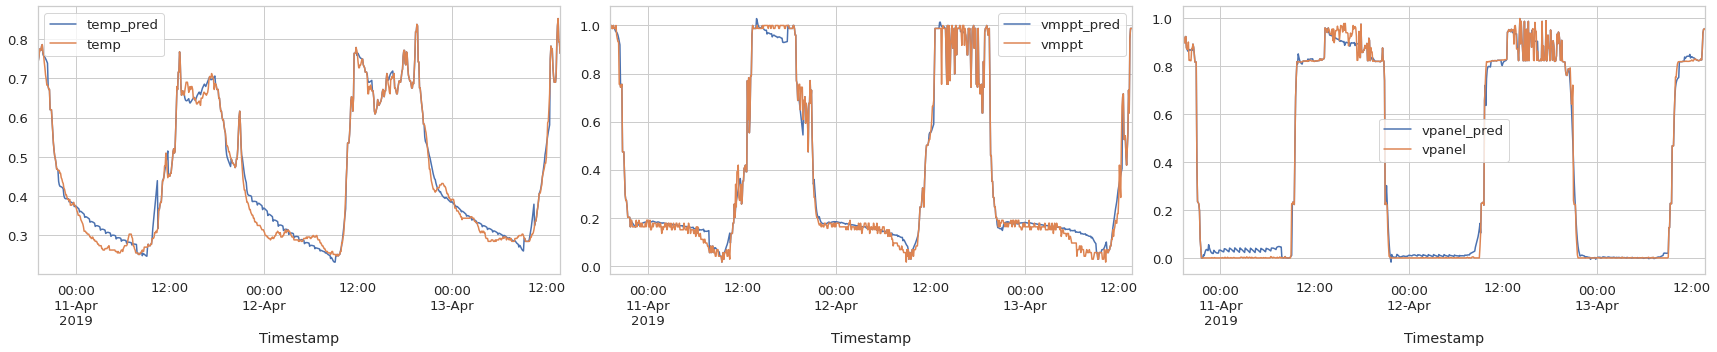

In [13]:
#--------------- this part is for plotting and create dataframes----------------------

print('Number of Sequences to transmit ',counter)

# reshape predictions
predictions_forecast = np.array(predictions_forecast).reshape(-1,3)
# reshape real values
forecast_truth = np.array(next_step_truth_list).reshape(-1,3)
# Stack error and real values
error_forecast = np.column_stack([predictions_forecast,forecast_truth])
# create dataframe with truth and error
error_forecast_df = pd.DataFrame(data=error_forecast, columns=['temp_pred','vmppt_pred','vpanel_pred','temp','vmppt','vpanel'])
# Set date index for dataframe taking
error_forecast_df = error_forecast_df.set_index(train_data[train_len:][:error_forecast_df.shape[0]].index)

# Create dataframe of errors > threshold
# error stack is the MAE calculated above and stacked
err = np.array(error_stack).reshape(-1,1)
err_df = pd.DataFrame(err, columns=['error'])
err_df = err_df.loc[err_df['error']>0.05]

fig, axx = plt.subplots(1, 3, figsize=(24,5))
error_forecast_df[['temp_pred','temp']].plot(ax=axx[0])
error_forecast_df[['vmppt_pred','vmppt']].plot(ax=axx[1])
error_forecast_df[['vpanel_pred','vpanel']].plot(ax=axx[2])
plt.tight_layout()

# Taking point by point

Step by step prediction checking error wth real data.In this case we transmit the different points only, not the entire batch

In [14]:
def forecast_for_tx(model, train_X, normalized_train, n_timesteps_out, pred_range=100, threshold=0.08):
  '''
  Function to make a forecast checking the error in prediction.
  If the error is too big, then the real values are copied t the prediction
  so next prediction will consider real points. This will diminish the error in
  forecast. Considering only error in temperature to make it simple.
  '''
  n_timesteps_in = train_X.shape[1]
  n_features = train_X.shape[-1]
  
  # next_bath starts with the last batch of the training set
  next_batch = train_X[-1, :, :]
  predictions_forecast = []
  next_step_truth_list = []
  counter = 0
  error_stack = []

  # Repeat a number of future timesteps
  for ii in range(pred_range):
    # Reshape to 3D for prediction
    next_step_pred = model.predict(next_batch.reshape(1, n_timesteps_in, n_features))
    # Reshape to 2D
    next_step_pred = next_step_pred.reshape(n_timesteps_out, n_features)

    # the real values are in normalized_train. Starting from train_len is the testing data set
    # which is the continuation (or truth) of the values predicted in from the last training batch
    # but only n_timesteps_out amounth. We have to shift the timesteps in validation by n_timesteps_out times 
    next_step_truth = normalized_train[train_len:][ii * n_timesteps_out : n_timesteps_out*(ii+1)]
    next_step_truth_list.append(next_step_truth)
    # calculate error
    error_temp = abs(next_step_truth[:,0] - next_step_pred[:,0])
    error_vmppt = abs(next_step_truth[:,1] - next_step_pred[:,1])
    error_vpanel = abs(next_step_truth[:,2] - next_step_pred[:,2])
    error = abs(next_step_truth - next_step_pred).mean()

    # Stack the rolling MAE for counting the points
    # Next we have to ensamble the data with the points and 
    # not with the sequences but for now let's just count
    error_temp = error_temp.reshape(-1,1).mean(axis=1)
    error_stack.append(error_temp)

    #transmitting points with higher error
    prep_batch = next_step_pred
    for elem in range(len(error_temp)):
      if error_temp[elem] > threshold:
        prep_batch[elem] = next_step_truth[elem]
        counter+=1

    predictions_forecast.append(prep_batch)
    # Take the next batch for predcition
    next_batch = np.row_stack([next_batch[n_timesteps_out:], prep_batch])

  # convert to numpy & reshape predictions
  predictions_forecast = np.array(predictions_forecast).reshape(-1,3)
  # convert to numpy & reshape real values
  forecast_truth = np.array(next_step_truth_list).reshape(-1,3)
  # Stack error and real values
  forecast_result = np.column_stack([predictions_forecast,forecast_truth])

  return error_stack, forecast_result, counter

Number of Points to transmit  30
Percent of Points transmitted  7.25


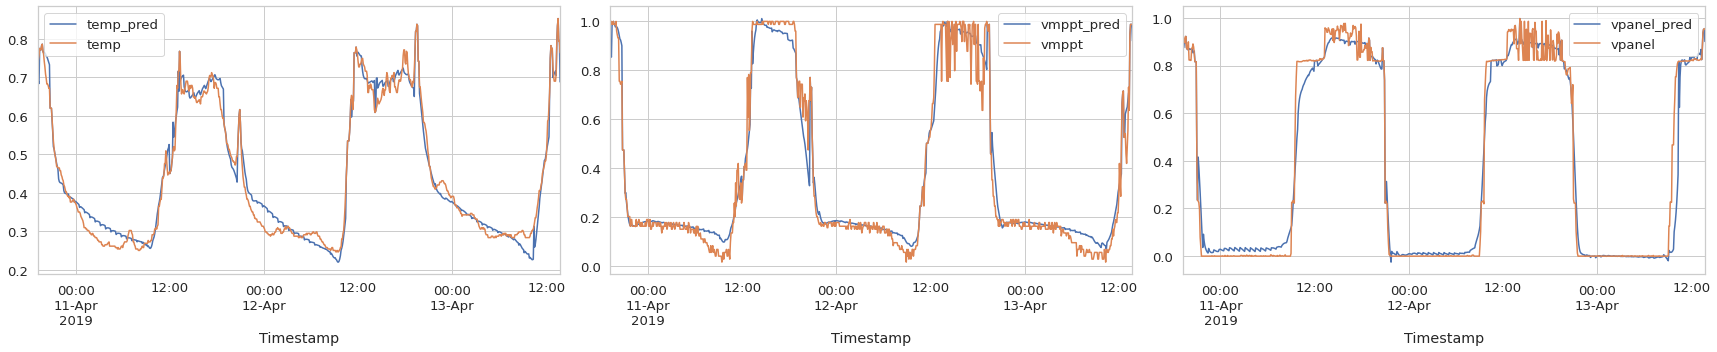

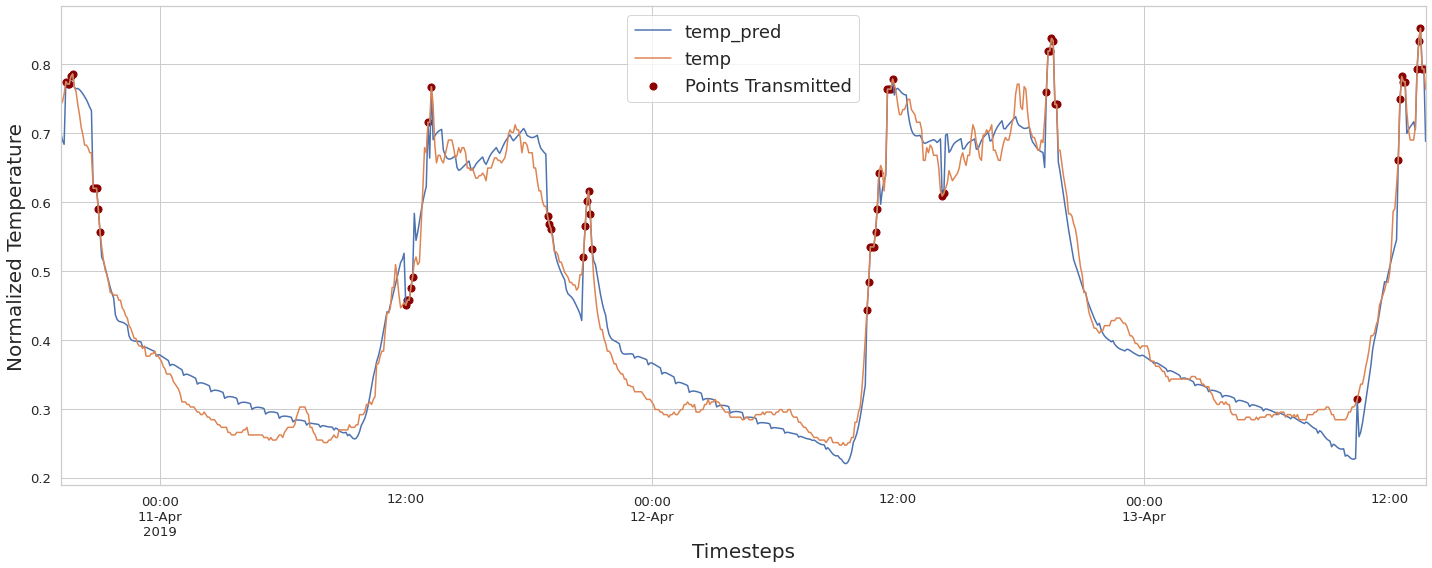

In [15]:
print('Number of Points to transmit ',counter)
error_stack, forecast_result, counter = forecast_for_tx(model_att, train_X, normalized_train, n_timesteps_out)

# create dataframe with truth and error
forecast_result_df = pd.DataFrame(data=forecast_result, columns=['temp_pred','vmppt_pred','vpanel_pred','temp','vmppt','vpanel'])
# Set date index for dataframe taking
forecast_result_df = forecast_result_df.set_index(train_data[train_len:][:forecast_result_df.shape[0]].index)
# error stack only contains temperature error
err = np.array(error_stack).reshape(-1,1)

fig, axx = plt.subplots(1, 3, figsize=(24,5))
forecast_result_df[['temp_pred','temp']].plot(ax=axx[0])
forecast_result_df[['vmppt_pred','vmppt']].plot(ax=axx[1])
forecast_result_df[['vpanel_pred','vpanel']].plot(ax=axx[2])
plt.tight_layout()

# add the error to the dataframe to plot the points
forecast_result_df['error'] = err
# compare with a threshold
forecast_result_df['Transmitted'] = (forecast_result_df['error'] > 0.08)
# create dataframe that contains points to be transmitted (to mark them as scatter later)
points_tx = pd.DataFrame(data = forecast_result_df[forecast_result_df['Transmitted']==True]['temp'],
                         index=forecast_result_df[forecast_result_df['Transmitted']==True].index)
# Plot
fig, ax1 = plt.subplots(1, 1, figsize=(20,8))
forecast_result_df[['temp_pred','temp']].plot(ax=ax1)
ax1.scatter(x=points_tx.index, y=points_tx['temp'],
                    color='darkred', label='Points Transmitted', s=50)
plt.xlabel('Timesteps', fontsize=20, y=1.03)
plt.ylabel('Normalized Temperature', fontsize=20)
plt.legend(fontsize=18)
plt.tight_layout()
plt.tight_layout()

print('Percent of Points transmitted ',(counter*100)/800)

# Checking multiple thresholds

To unnormalize just multiply by the max value wich is 43.5

In [16]:
count_list = []
percent_list=[]
error_list = []
std_list = []
rolling_mae = []
for ii in np.linspace(0.020, 0.15, 50):
    error_stack, forecast_result, counter = forecast_for_tx(model_att, train_X, normalized_train, n_timesteps_out, threshold=ii)
    count_list.append(counter)
    percent_list.append((counter*100)/800)
    error_list.append(abs(forecast_result[:,0] - forecast_result[:,3]).mean() * 43.5)
    std_list.append(abs(forecast_result[:,0] - forecast_result[:,3]).std())
    rolling_mae.append(abs(forecast_result[:,0] - forecast_result[:,3]).reshape(-1,1).mean(axis=1))

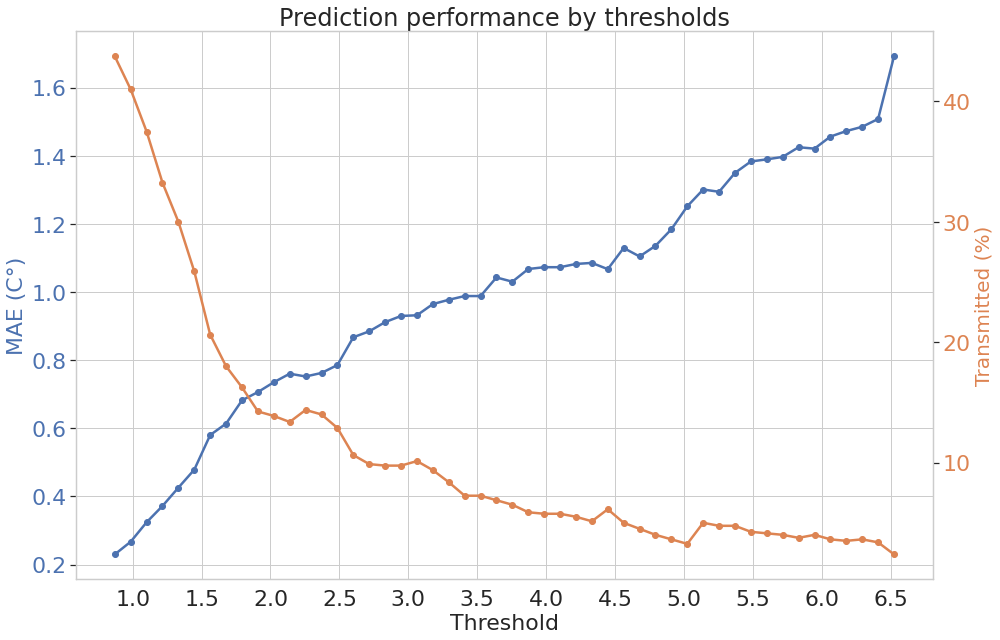

In [17]:
bars = False
fig, ax1 = plt.subplots(1,1, figsize=(14,9))
if bars==True:
    ax1.errorbar(np.linspace(0.020, 0.15, 50)*43.5, np.array(error_list),yerr=np.array(std_list)*43.5, linewidth=2.5, fmt='-o',)
else:
    ax1.plot(np.linspace(0.020, 0.15, 50)*43.5, np.array(error_list), linewidth=2.5, marker='o')
    ax1.set_title('Prediction performance by thresholds', fontsize=24)
    ax1.set_ylabel('MAE (C\N{DEGREE SIGN})', fontsize=22, color=sns.color_palette('deep')[0])
    ax1.set_xlabel('Threshold', fontsize=22)
    ax1.xaxis.set_tick_params(labelsize=22)
    ax1.yaxis.set_tick_params(labelsize=22, labelcolor=sns.color_palette('deep')[0])
    ax1.set_xticks(np.arange(0.5, 7, 0.5))

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    ax2.plot(np.linspace(0.020, 0.15, 50)*43.5, percent_list, color=sns.color_palette('deep')[1], linewidth=2.5, marker='o')
    ax2.set_xlabel('Threshold \n b)', fontsize=20)
    ax2.set_ylabel('Transmitted (%)', fontsize=20, color=sns.color_palette('deep')[1])
    ax2.grid(b=False)
    ax2.xaxis.set_tick_params(labelsize=22)
    ax2.yaxis.set_tick_params(labelsize=22, labelcolor=sns.color_palette('deep')[1])
    plt.tight_layout()

    fig.savefig('Thresholds_sweep.pdf', bbox_inches='tight')

### Comparing two different prediction with different thresholds

In [55]:
# Comparing two forecast
# Threshols = 0.03, 0.07
error_stack, forecast_result, counter = forecast_for_tx(model_att, train_X, normalized_train, n_timesteps_out, threshold=0.02)
forecast_result_df = pd.DataFrame(data=forecast_result, columns=['temp_pred','vmppt_pred','vpanel_pred','temp','vmppt','vpanel'])
forecast_result_df = forecast_result_df.set_index(train_data[train_len:][:forecast_result_df.shape[0]].index)
# Threshols = 0.08
error_stack_2, forecast_result_2, counter_2 = forecast_for_tx(model_att, train_X, normalized_train, n_timesteps_out, threshold=0.057)
forecast_result_df_2 = pd.DataFrame(data=forecast_result_2, columns=['temp_pred','vmppt_pred','vpanel_pred','temp','vmppt','vpanel'])
forecast_result_df_2 = forecast_result_df_2.set_index(train_data[train_len:][:forecast_result_df_2.shape[0]].index)
print(counter)
print(counter_2)

395
105


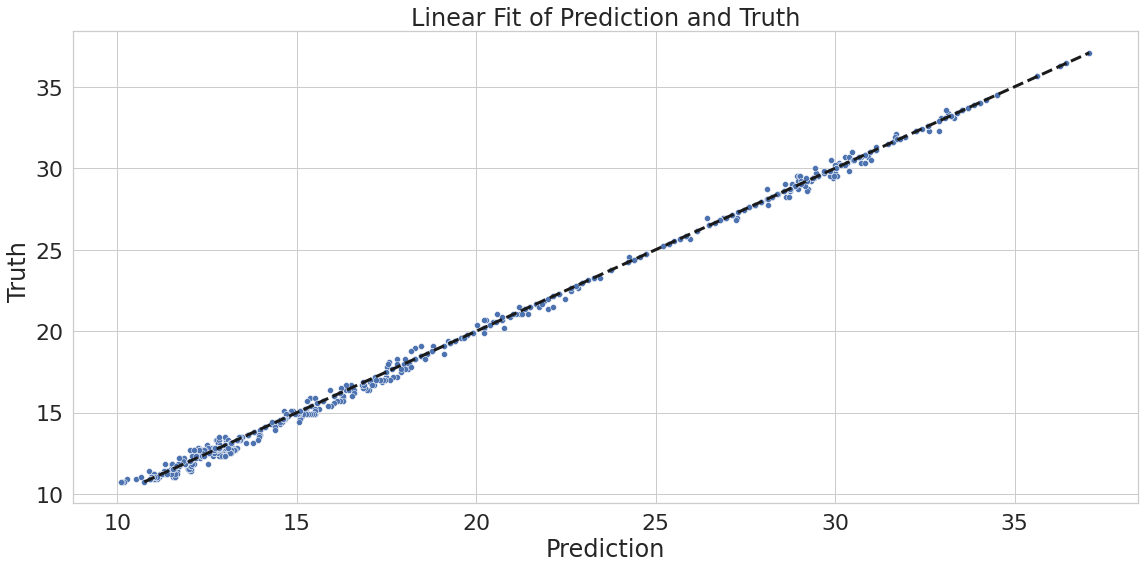

In [56]:
# Need to convert the list to numpy array and reshape to column form
x = np.array(forecast_result[:,0]).reshape(-1,1)
y = np.array(forecast_result[:,3]).reshape(-1,1)

# Scatter between prediction and real data to check accuracy
fig, ax1 = plt.subplots(1,1,figsize=(16,8))
sns.scatterplot(x=forecast_result[:,0]*43.5, y=forecast_result[:,3]*43.5, ax=ax1)
ax1.plot([y.min()*43.5, y.max()*43.5], [y.min()*43.5, y.max()*43.5], 'k--', lw=3)
ax1.set_title(label='Linear Fit of Prediction and Truth', fontsize=24)
ax1.set_xlabel('Prediction', fontsize=24)
ax1.set_ylabel('Truth ', fontsize=24)
ax1.xaxis.set_tick_params(labelsize=22)
ax1.yaxis.set_tick_params(labelsize=22)
plt.tight_layout()

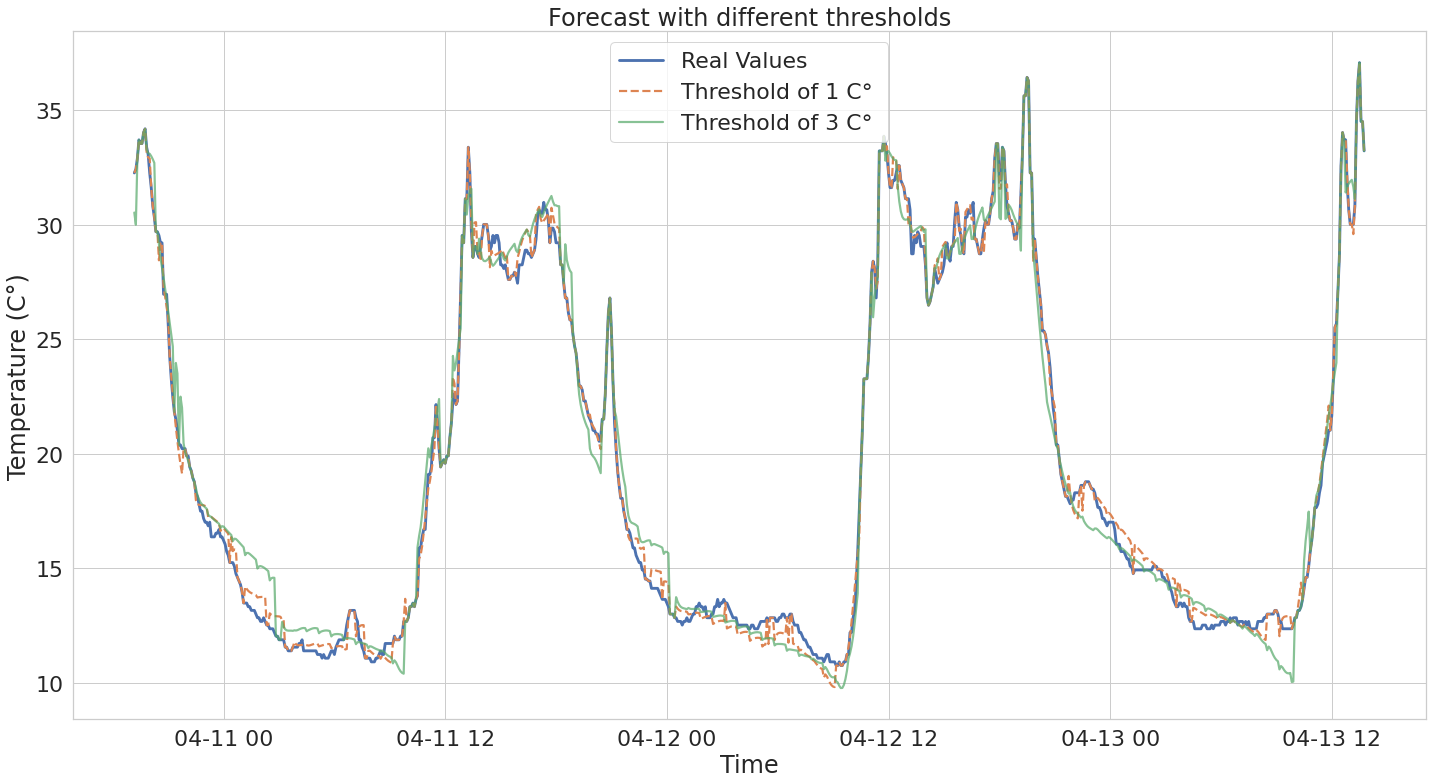

In [ ]:
fig, axx = plt.subplots(1, 1, figsize=(20,11))
# Multiplying by Max value of temperature
axx.plot(forecast_result_df['temp']*43.5, label = 'Real Values', linewidth=2.85)
axx.plot(forecast_result_df[['temp_pred']]*43.5, label='Threshold of 1 C\N{DEGREE SIGN} ', linewidth=2.2, linestyle='--')
axx.plot(forecast_result_df_2[['temp_pred']]*43.5, label = 'Threshold of 3 C\N{DEGREE SIGN}', linewidth=2.2,alpha=0.7)
plt.title(label='Forecast with different thresholds', fontsize=24)
plt.xlabel('Time', fontsize=24)
plt.ylabel('Temperature (C\N{DEGREE SIGN})', fontsize=24)
axx.xaxis.set_tick_params(labelsize=22)
axx.yaxis.set_tick_params(labelsize=22)
plt.legend(fontsize=22, loc='upper center')
plt.tight_layout()
fig.savefig('Compare_thresholds.pdf', bbox_inches='tight')